In [1]:
import torch
from pathlib import Path
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torch.nn import MSELoss
from captum.attr import GradientShap, IntegratedGradients, Saliency
import matplotlib.pyplot as plt 
import pathlib
import torch.nn.functional as F

from lfxai.models.images import AutoEncoderMnist, EncoderMnist, DecoderMnist, ClassifierMnist
from lfxai.models.pretext import Identity
from lfxai.explanations.features import attribute_auxiliary, attribute_auxiliary_v2
from lfxai.explanations.examples import SimplEx

from tqdm import tqdm
from Experiments_MNIST import compute_vector_direction, find_border, shift_image_horizontally
from scores import Cosine, Score_Direction_dot
import numpy as np

%load_ext autoreload
%autoreload 2

c:\Users\benja\anaconda3\envs\ExplAI\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading/Training the model

In [2]:

# Select torch device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Load data
data_dir = Path.cwd() / "data/mnist"
train_dataset = MNIST(data_dir, train=True, download=True)
test_dataset = MNIST(data_dir, train=False, download=True)
train_dataset.transform = transforms.Compose([transforms.ToTensor()])
test_dataset.transform = transforms.Compose([transforms.ToTensor()])
train_loader = DataLoader(train_dataset, batch_size=100)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

In [3]:
# Get a model
encoder = EncoderMnist(encoded_space_dim=10)
# decoder = DecoderMnist(encoded_space_dim=10)
# model = AutoEncoderMnist(encoder, decoder, latent_dim=10, input_pert=Identity())
# model = ClassifierMnist(encoder, latent_dim=10, name = 'sym', bias = False)
model = ClassifierMnist(encoder, latent_dim=10, name = 'sym', bias = True)
model.to(device)

ClassifierMnist(
  (encoder): EncoderMnist(
    (encoder_cnn): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace=True)
      (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
      (6): ReLU(inplace=True)
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (encoder_lin): Sequential(
      (0): Linear(in_features=288, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=10, bias=True)
    )
  )
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running

In [68]:
### fit or save
# model.fit(device, train_loader, test_loader, save_dir = pathlib.Path('.'))
model.load(directory='./sym.pt')
# model.load(directory='sym_nobias.pt')
weight_matrix = model.lin_output[0].weight.detach()
vector_directions = compute_vector_direction(weight_matrix)

In [5]:
model.test_epoch(device, test_loader) ### the testing accuracy is quite good, no need to further train it I think

(1.4735445, 0.9879999999999999)

# Observe the saliency maps

In [69]:
baseline = torch.zeros((1, 1, 28, 28)).to(device) # black image as baseline


### choose your feature importance method 


# attr_method = IntegratedGradients(model)
# attr_method = Saliency(model)
attr_method = GradientShap(model)

In [81]:
### compute the saliency maps 

feature_importance_initial = attribute_auxiliary(encoder, test_loader,
                                         device, attr_method, baseline)

feature_importance = attribute_auxiliary_v2(encoder, test_loader,
                                         device, attr_method, vector_directions, baseline)

100%|██████████| 100/100 [00:02<00:00, 34.11it/s]


In [89]:
### compute the saliency maps 

feature_importance_initial = attribute_auxiliary(encoder, test_loader,
                                         device, attr_method, baseline)

feature_importance = attribute_auxiliary_v2(encoder, test_loader,
                                         device, attr_method, vector_directions, baseline)

100%|██████████| 100/100 [00:02<00:00, 36.24it/s]


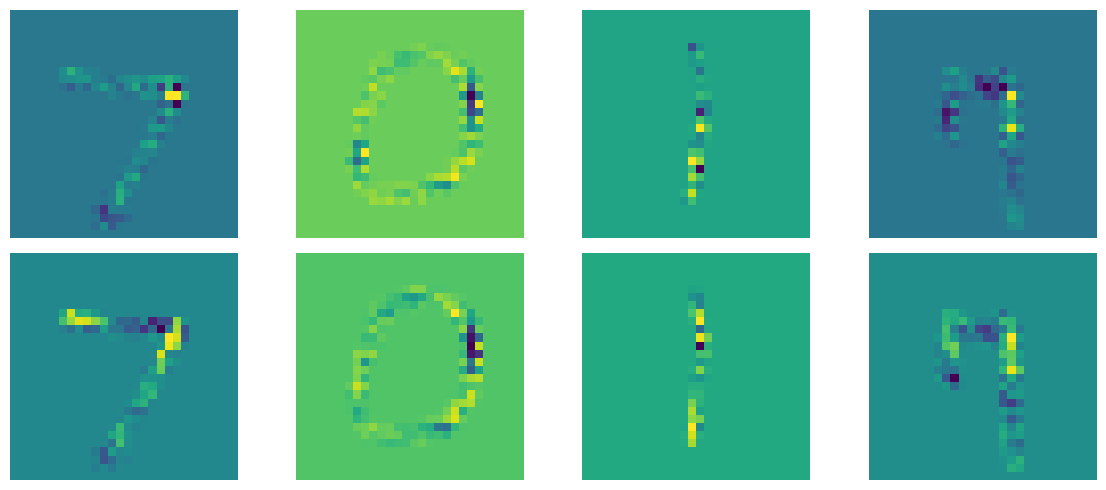

In [8]:

# Assuming feature_importance_initial is a list/array of images
idx = [0, 10, 40, 80]
# Create a figure and axis objects
fig, axes = plt.subplots(2, len(idx), figsize=(12, 5))

# Plot each image in the specified indices
for i, index in enumerate(idx):
    axes[0,i].imshow(feature_importance_initial[index, 0])
    # axes[0,i].set_title(f'Index {index}')  # Optional: Set title for each subplot
    axes[0,i].axis('off')  # Optional: Turn off axis for each subplot

for i, index in enumerate(idx):
    axes[1,i].imshow(feature_importance[index, 0])
    #axes[i].set_title(f'Index {index}')  # Optional: Set title for each subplot
    axes[1,i].axis('off')  # Optional: Turn off axis for each subplot
    
    # Set titles for the rows


plt.subplots_adjust(wspace=0, hspace=0.001)
plt.tight_layout()

plt.show()


# Study the symmetries

In [72]:
from Experiments_MNIST import evolution_symmetry, plot_res

In [73]:
test_loader_bs1 = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [74]:
L_scores = [Cosine(), Score_Direction_dot(vector_directions)] ### 
res = evolution_symmetry(test_loader_bs1, L_scores, model, device)

100%|██████████| 10000/10000 [00:40<00:00, 247.38it/s]


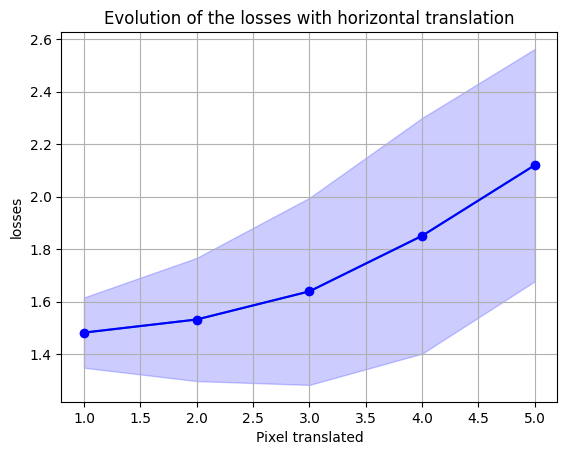

In [80]:
plot_res(res, 'losses', H = 5, H_max = 7)